# Classification Main-Pied

## Apprentissage sur stimulation; Test sur imagination

Cerveau Entier - Parcellation BASC (444 régions)

Tous les sujets - SVM Linéaire


In [19]:
import numpy as np
from gsplearn.GSPPlot import plot_selectedregions
from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
%matplotlib inline

In [45]:
# Import data
names='ap','as','bh','bi','cmp','cas','cs','cb','gm','gn','gbn','mv','ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs'
smt='ss'
fold_g = 'F:/IRM_Marche/'
label_i=np.loadtxt(fold_g+'label_main.txt','S12')

roi=np.zeros([0,444])
rest=np.zeros([0,444])
label=np.zeros([0,3])
for n in names:
    sim_filename=fold_g+'mni4060/roi_'+smt+'_'+n+'.npz'
    rest_filename=  fold_g+'mni4060/roirest_'+smt+'_'+n+'.npz'  
    tmproi=np.load(sim_filename)['roi']
    tmprest=np.load(rest_filename)['roi']
    roi=np.concatenate((roi,tmproi))
    rest=np.concatenate((rest,tmprest))
    label=np.append(label,label_i,axis=0)
    
# Remove first volumes per block    
index=[]
for x in range(label.shape[0]):
    if label[x,0]!=label[x-1,0]:
        index.append(x)
    elif label[x,0]!=label[x-2,0]:
        index.append(x)
        
label=np.delete(label,index,0)
roi=np.delete(roi,index,0)

condition_cat = np.logical_or(label[:,1] == b'foot', label[:,1] == b'hand')
condition_out=np.logical_not(label[:,2]== b'des')
condition_mask= condition_cat==condition_out

y=label[condition_mask]
cond=roi[condition_mask]
   
train_mask= y[:,0]==b'stim'
test_mask= y[:,0]==b'imag'
y_train=y[train_mask,1]
y_test=y[test_mask,1]
roi_train=cond[train_mask]#   
roi_test=cond[test_mask]

In [59]:
# Classification
scaler = preprocessing.StandardScaler()
svm= SVC(C=1., kernel="linear")  
k=60
feature_selection = SelectKBest(f_classif, k=k)
    
pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('classif_name', svm)])
pipeline_anova.fit(roi_train, y_train)
prediction = pipeline_anova.predict(roi_test)  
print('Accuracy:',accuracy_score(prediction,y_test)*100,'%')

Accuracy: 59.9681020734 %


In [17]:
# Prepare ploting
basc = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale444']
brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory_level=1, verbose=0,
                           detrend=True, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels'
                           )
masker.fit()

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


NiftiLabelsMasker(background_label=0, detrend=True, high_pass=0.01,
         labels_img='C:\\Users\\mmenoret/nilearn_data\\basc_multiscale_2015\\template_cambridge_basc_multiscale_nii_sym\\template_cambridge_basc_multiscale_sym_scale444.nii.gz',
         low_pass=None,
         mask_img=<nibabel.nifti1.Nifti1Image object at 0x000000000C128F28>,
         memory=Memory(cachedir=None), memory_level=1,
         resampling_target='labels', sessions=None, smoothing_fwhm=None,
         standardize=False, t_r=2.28, verbose=0)

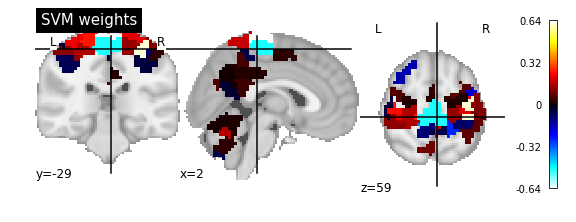

In [55]:
# Plot resulting weights of the SVM & selected regions
weights=pipeline_anova.named_steps['classif_name'].coef_
index=plot_selectedregions(pipeline_anova,masker,weights=weights,anova_name='anova')


Résultats: La classification imagination MAIN/PIED à partir de l'apprentissage de Stimulation MAIN/PIED donne des performances proches de 60 %, et vu le niveau de difficulté (cerveau entier, tache différente entre imagination et stimulation), c'est pas si mal!

Concernant les coefficients du SVM obtenus (c'est à dire les régions qui permettent la classification), on retrouve parfaitement les régions motrices de la main et du pied).

## Apprentissage sur imagination; Test sur stimulation

Attention, vu que les taches diffèrent également au niveau visuel, la classification sur cerveau entier risque d'être faite sur le cortex visuel

In [56]:
pipeline_anova.fit(roi_test, y_test)
prediction = pipeline_anova.predict(roi_train)  
print('Accuracy:',accuracy_score(prediction,y_train)*100,'%')

Accuracy: 66.4673046252 %


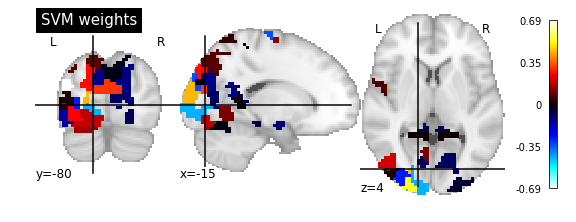

In [57]:
# Plot resulting weights of the SVM & selected regions
weights=pipeline_anova.named_steps['classif_name'].coef_
index=plot_selectedregions(pipeline_anova,masker,weights=weights,anova_name='anova')

Résultats: La classification des données Stimulation MAIN/PIED donne de meilleures performances: 66 %, 
mais quand on regarde les coefficients du SVM obtenus (c'est à dire les régions qui permettent la classification),
on retrouve seulement les régions visuelles, donc probablement dues a des différences autres que motrices.
Etant donné la différence dans le conditions de l'input visuel, il est impossible d'interpreter ces poids.